## PHẦN 1: CÀI ĐẶT, IMPORTS & THIẾT LẬP BAN ĐẦU

In [1]:
# ==============================================================================
# CELL 1.1: CÀI ĐẶT THƯ VIỆN & BIẾN MÔI TRƯỜNG (CẬP NHẬT)
# ==============================================================================
import os
import json
import asyncio
import operator
import time 
import re
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union

# Tải các biến môi trường
from dotenv import load_dotenv 
load_dotenv()

# LangChain & LangGraph
from langchain_core.messages import BaseMessage, HumanMessage   
from pydantic.v1 import BaseModel, Field, schema_json_of
# --- NÂNG CẤP: Chuyển sang thư viện Google Generative AI (dành cho AI Studio) ---
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# --- NÂNG CẤP: Thêm công cụ tìm kiếm ---
from langchain_community.tools.tavily_search import TavilySearchResults

# Thư viện hỗ trợ & Kho tri thức
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from rich.console import Console
from rich.markdown import Markdown
from rich.pretty import pprint
from IPython.display import Image, display

In [2]:
# ==============================================================================
# CELL 1.2: CẤU HÌNH LOG & CÁC HÀM IN ẤN
# ==============================================================================
from langchain_groq import ChatGroq
# --- CẤU HÌNH LOG ---
VERBOSE_MODE = True

# --- KHỞI TẠO CÁC CÔNG CỤ IN ẤN ---
console = Console()

def print_step(message: str):
    if VERBOSE_MODE:
        console.print(f"\n[bold cyan]>[/bold cyan] {message}")

def print_result(data: Any, title: str = "Kết quả"):
    if VERBOSE_MODE:
        console.print(f"[bold green]✔️ {title}:[/bold green]")
        pprint(data, expand_all=True)
        
def print_warning(message: str):
    if VERBOSE_MODE:
        console.print(f"[bold yellow]⚠️  {message}[/bold yellow]")

In [3]:
# ==============================================================================
# CELL 1.3: KHỞI TẠO LLM (NÂNG CẤP SANG GOOGLE AI STUDIO)
# ==============================================================================
try:
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash", # Sử dụng model mới nhất và mạnh nhất
        temperature=0.1,
        google_api_key=os.getenv("GOOGLE_API_KEY")
    )
    print("✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.")
except Exception as e:
    print(f"❌ LỖI: Không thể khởi tạo LLM. Hãy chắc chắn bạn đã cài 'langchain-google-genai' và có GOOGLE_API_KEY trong file .env. Lỗi: {e}")
    llm = None

✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.


## PHẦN 2: ĐỊNH NGHĨA STATE CỦA HỆ THỐNG


In [4]:
# ==============================================================================
# CELL 1.4: TẢI KHO TRI THỨC (RAG)
# ==============================================================================
# --- TẢI KHO TRI THỨC ---
BASE_VECTOR_STORE_PATH = "vector_store"
vector_store = None
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

if os.path.exists(BASE_VECTOR_STORE_PATH):
    subdirectories = [f.path for f in os.scandir(BASE_VECTOR_STORE_PATH) if f.is_dir()]
    if not subdirectories:
        print(f"❌ LỖI: Không tìm thấy thư mục con nào trong '{BASE_VECTOR_STORE_PATH}'.")
    else:
        try:
            print_step(f"Đang tải và hợp nhất các kho tri thức từ {len(subdirectories)} thư mục...")
            # Tải kho tri thức đầu tiên để làm cơ sở
            first_store_path = subdirectories.pop(0)
            vector_store = FAISS.load_local(first_store_path, embeddings, allow_dangerous_deserialization=True)
            print(f"✅ Đã tải thành công kho tri thức cơ sở: '{os.path.basename(first_store_path)}'")

            # Hợp nhất các kho tri thức còn lại
            for store_path in subdirectories:
                if os.path.exists(os.path.join(store_path, "index.faiss")):
                    temp_store = FAISS.load_local(store_path, embeddings, allow_dangerous_deserialization=True)
                    vector_store.merge_from(temp_store)
                    print(f"✅ Đã hợp nhất thành công: '{os.path.basename(store_path)}'")
                else:
                    print_warning(f"Bỏ qua thư mục '{os.path.basename(store_path)}' vì không chứa file index.faiss.")
            
            print("\n[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]")

        except Exception as e:
            print(f"❌ LỖI trong quá trình tải hoặc hợp nhất kho tri thức: {e}")
else:
    print(f"❌ LỖI: Không tìm thấy thư mục gốc của kho tri thức tại '{BASE_VECTOR_STORE_PATH}'.")


c:\Users\Hi\Documents\IAI - UET\AI-Lesson-Plan-Generator\plan_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


> Đang tải và hợp nhất các kho tri thức từ 2 thư mục...

✅ Đã tải thành công kho tri thức cơ sở: 'sgk_toan_12_1'
✅ Đã hợp nhất thành công: 'sgk_toan_9_1'

[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]


In [5]:
# ==============================================================================
# CELL 1.5: KHỞI TẠO VÀ QUẢN LÝ TRÍ NHỚ DÀI HẠN (NÂNG CẤP V9.4)
# ==============================================================================
MEMORY_FILE_PATH = "long_term_memory.json"
memory_vector_store = None

# Hàm để tải trí nhớ từ file JSON
def load_memory():
    if not os.path.exists(MEMORY_FILE_PATH):
        return []
    with open(MEMORY_FILE_PATH, 'r', encoding='utf-8') as f:
        return json.load(f)

# Hàm để lưu một giáo án mới vào trí nhớ
def save_to_memory(request: str, structured_plan: Dict[str, Any]):
    memory = load_memory()
    memory.append({
        "request": request,
        "plan": structured_plan
    })
    with open(MEMORY_FILE_PATH, 'w', encoding='utf-8') as f:
        json.dump(memory, f, ensure_ascii=False, indent=2)
    print_step("🧠 Đã lưu giáo án thành công vào Trí nhớ Dài hạn.")

# Hàm để tạo một vector store từ trí nhớ (để tìm kiếm tương đồng)
def build_memory_vector_store():
    global memory_vector_store
    memory_content = load_memory()
    if not memory_content:
        print_warning("Trí nhớ trống, không có gì để xây dựng vector store.")
        return

    # Chỉ lấy phần 'request' để tìm kiếm
    texts = [item['request'] for item in memory_content]
    # Lưu toàn bộ item làm metadata
    metadatas = memory_content
    
    memory_vector_store = FAISS.from_texts(texts, embeddings, metadatas=metadatas)
    print_step("✅ Đã xây dựng Vector Store cho Trí nhớ Dài hạn.")

# Tự động xây dựng vector store khi khởi động notebook
build_memory_vector_store()

> ✅ Đã xây dựng Vector Store cho Trí nhớ Dài hạn.

In [6]:
# ==============================================================================
# CELL 2.1: ĐỊNH NGHĨA STATE NÂNG CAO (v9.0)
# ==============================================================================
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
import operator

# --- Hàm tiện ích (giữ nguyên) ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

# --- Cấu trúc dữ liệu con (giữ nguyên) ---
class DetailedTask(TypedDict):
    task_id: int
    task_name: str
    task_description: str
    estimated_duration: int 
    status: Literal["pending", "completed"]

# === NÂNG CẤP V9.0: CÁC CẤU TRÚC DỮ LIỆU MỚI CHO TƯ DUY SÂU ===
class DifferentiatedInstruction(TypedDict):
    """Gợi ý cho việc dạy học phân hóa trong một hoạt động."""
    for_struggling_students: str
    for_advanced_students: str

class StructuredContentItem(TypedDict):
    """Định nghĩa một hoạt động hoặc đánh giá có cấu trúc."""
    task_id: int
    activity_name: str
    question_or_description: str # Gộp 'question' và 'description'
    duration_minutes: int
    content_type: str # Gộp 'activity_type' và 'question_type'
    teacher_actions: List[str]
    solution_guide: Any
    answer: Optional[str] # Dành cho câu hỏi đánh giá
    differentiation: Optional[DifferentiatedInstruction]

class FinalStructuredPlan(TypedDict):
    """Định nghĩa cấu trúc JSON cho giáo án cuối cùng."""
    general_info: Dict[str, Any]
    learning_objectives: List[str]
    preparation: Dict[str, List[str]]
    knowledge_summary: str
    lesson_flow: List[StructuredContentItem]
    # pedagogical_explainer: Dict[str, Any] # Dành cho nâng cấp tương lai

# === NÂNG CẤP V9.0: STATE MỚI VỚI CÁC TRƯỜNG TRÍ TUỆ MỚI ===
class TeacherStateV5(TypedDict):
    # Các trường cơ bản
    original_request: str
    messages: Annotated[List[BaseMessage], add_messages]
    domain: Optional[str]
    
    # === NÂNG CẤP: student_persona giờ sẽ chứa cả chiến lược phân hóa ===
    student_persona: Optional[Dict[str, Any]] 
    
    # Các bước tuần tự ban đầu
    analyzed_objective: Optional[Any]
    pedagogy_strategy: Optional[Any]
    pedagogical_blueprint: Optional[List[str]]

    # Các trường nâng cao
    expanded_queries: Optional[List[str]]
    task_list: Optional[List[DetailedTask]]
    current_task_id: Optional[int]
    current_task_retry_count: int  # <-- THÊM DÒNG NÀY VÀO ĐÂY
    reflection_notes: Optional[str]
    agent_outputs: Annotated[Dict[str, Any], merge_dicts] 
    next_agent: str
    
    # Các trường tạm thời cho vòng lặp kiểm duyệt vi mô (Micro-loop)
    current_content_to_validate: Optional[Dict[str, Any]]
    validation_feedback: Optional[str]

    inspirational_example: Optional[List[Dict[str, Any]]]

    # === NÂNG CẤP: Output cuối cùng sẽ có 2 dạng ===
    final_structured_plan: Optional[FinalStructuredPlan] # Dạng JSON có cấu trúc
    final_markdown_plan: Optional[str] # Dạng Markdown để hiển thị


print("✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.")

✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.


In [7]:
# ==============================================================================
# CELL 2.2: NODE KHỞI TẠO STATE
# ==============================================================================
def initialize_state_node(state: TeacherStateV5) -> Dict[str, Any]:
    """
    Node đầu tiên trong graph.
    Lấy yêu cầu gốc từ tin nhắn đầu vào và điền vào trường 'original_request'.
    """
    print_step("`Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...")
    user_request = state['messages'][-1].content
    return {"original_request": user_request}

print("✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.")

✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.


## PHẦN 3: ĐỊNH NGHĨA CÁC AGENT

In [8]:
# ==============================================================================
# CELL 3.1: HÀM TIỆN ÍCH & CẤU TRÚC DỮ LIỆU (v9.7 - TƯ DUY LINH HOẠT)
# ==============================================================================
import json
from pydantic.v1 import BaseModel, Field, schema_json_of
from typing import List, Dict, Any, Literal, Optional

# --- Các hàm tiện ích giữ nguyên ---
def format_solution_guide(guide: Any) -> str:
    if not guide: return "Chưa có hướng dẫn."
    if isinstance(guide, str): return guide
    if isinstance(guide, list): return "\n".join(f"- {step}" for step in guide)
    if isinstance(guide, dict): return "\n".join(f"- {key.replace('_', ' ').title()}: {value}" for key, value in guide.items())
    return str(guide)

def format_teacher_actions(actions: Optional[List[str]]) -> str:
    if not actions: return "Giáo viên quan sát và hỗ trợ chung."
    return "\n".join(f"  - {action}" for action in actions)

def update_agent_outputs(state: "TeacherStateV5", key: str, value: Any) -> Dict[str, Any]:
    outputs = state.get("agent_outputs", {}).copy()
    if key not in outputs: outputs[key] = []
    outputs[key].append(value)
    return {"agent_outputs": outputs}

SYSTEM_PERSONA_PROMPT = "BẠN LÀ MỘT TRỢ LÝ AI CHUYÊN NGHIỆP, ĐÓNG VAI TRÒ MỘT GIÁO VIÊN GIÀU KINH NGHIỆM TẠI VIỆT NAM. LUÔN LUÔN trả lời bằng TIẾNG VIỆT."

# === CẬP NHẬT CẤU TRÚC HOẠT ĐỘNG LINH HOẠT ===
class DifferentiatedInstructionModel(BaseModel):
    for_struggling_students: str = Field(description="Gợi ý cụ thể cho nhóm học sinh yếu/gặp khó khăn.")
    for_advanced_students: str = Field(description="Gợi ý, thử thách hoặc hoạt động nâng cao cho nhóm học sinh giỏi.")

class LearningActivity(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động học tập.")
    activity_type: str = Field(description="Phân loại hoạt động. Ví dụ: 'Thảo luận nhóm', 'Thực hành cá nhân'")
    duration_minutes: int = Field(description="Tổng thời gian ước tính (bằng SỐ PHÚT) cho cả hai phần.")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN.")
    # Thay 'description' bằng cấu trúc Lõi/Mở rộng
    core_component: str = Field(description="Mô tả phần hoạt động CỐT LÕI mà TẤT CẢ học sinh cần hoàn thành.")
    extension_component: Optional[str] = Field(description="Mô tả phần hoạt động MỞ RỘNG dành cho học sinh làm nhanh hoặc nếu còn dư thời gian.")
    solution_guide: Optional[Any] = Field(description="Hướng dẫn giải hoặc các câu hỏi gợi mở.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này.")

class AssessmentItem(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động đánh giá.")
    question_type: str = Field(description="Loại câu hỏi. Ví dụ: 'Tự luận', 'Trắc nghiệm'")
    duration_minutes: int = Field(description="Tổng thời gian ước tính (bằng SỐ PHÚT) cho cả hai phần.")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN.")
    # Thay 'question' bằng cấu trúc Lõi/Mở rộng
    core_component: str = Field(description="Nội dung câu hỏi hoặc đề bài CỐT LÕI mà TẤT CẢ học sinh cần hoàn thành.")
    extension_component: Optional[str] = Field(description="Câu hỏi phụ hoặc thử thách MỞ RỘNG dành cho học sinh làm nhanh hoặc nếu còn dư thời gian.")
    answer: str = Field(description="Đáp án chính xác và ngắn gọn cho phần CỐT LÕI.")
    solution_guide: Any = Field(description="Hướng dẫn giải chi tiết từng bước.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này.")

# --- Các model khác giữ nguyên ---
class StudentPersona(BaseModel):
    learning_pace: Literal["nhanh", "trung bình", "chậm"] = Field(description="Tốc độ học tập chung của lớp.")
    engagement_style: Literal["chủ động", "thụ động", "hỗn hợp"] = Field(description="Mức độ tham gia chung của lớp.")
    special_notes: str = Field(description="Tóm tắt các đặc điểm nổi bật của lớp học.")

class StudentPersonaAndDifferentiation(StudentPersona):
    differentiation_strategy: DifferentiatedInstructionModel = Field(description="Chiến lược dạy học phân hóa tổng thể cho cả bài học dựa trên các đặc điểm của lớp.")

class DetailedTaskModel(BaseModel):
    task_name: str = Field(description="Tên của nhiệm vụ này.")
    task_description: str = Field(description="Mô tả chi tiết nhiệm vụ cần thực hiện.")
    estimated_duration: int = Field(description="Thời gian ước tính (bằng phút) cho nhiệm vụ này.")

class TaskListWithDuration(BaseModel):
    tasks: List[DetailedTaskModel]

class DetailedPedagogyChoice(BaseModel):
    name: str = Field(description="Tên của phương pháp sư phạm được chọn.")
    rationale: str = Field(description="Lý do tại sao phương pháp này phù hợp.")
    key_actions: List[str] = Field(description="Danh sách các hành động/hoạt động cốt lõi đặc trưng cho phương pháp này.")

class ValidationResult(BaseModel):
    is_valid: bool = Field(description="Nội dung có hợp lệ và chính xác về mặt chuyên môn không.")
    feedback: str = Field(description="Phản hồi chi tiết. Nếu không hợp lệ, hãy giải thích rõ ràng lỗi sai và gợi ý cách sửa.")
    suggested_duration: Optional[int] = Field(default=None, description="Nếu có lỗi về thời gian, hãy đề xuất một thời lượng hợp lý hơn (tính bằng SỐ PHÚT).")
    corrected_content: Optional[Union[LearningActivity, AssessmentItem]] = Field(default=None, description="Nếu nội dung gốc không hợp lệ, hãy cung cấp một phiên bản đã được sửa đổi, cắt gọt để vừa với thời gian cho phép tại đây.")

class Domain(BaseModel): domain: str = Field(description="Lĩnh vực học thuật chính của yêu cầu.")
class ExpandedQueries(BaseModel): queries: List[str]
class BestSnippets(BaseModel): best_snippets: List[str]
class ParsedObjective(BaseModel): action_verb: str; bloom_level: int; topic: str; grade_level: str; duration_minutes: Optional[int]
class TaskClassification(BaseModel): agent_category: Literal["activity_designer", "theory_synthesizer", "assessment_creator"]
class BlueprintStage(BaseModel): stage_name: str; stage_objective: str; stage_direction: str
class PedagogicalBlueprint(BaseModel): blueprint: List[BlueprintStage]

print("✅ Các cấu trúc dữ liệu Pydantic (v9.7 - Hoạt động Linh hoạt) đã được định nghĩa.")

✅ Các cấu trúc dữ liệu Pydantic (v9.7 - Hoạt động Linh hoạt) đã được định nghĩa.


In [9]:
# ==============================================================================
# CELL 3.2: AGENT PHÂN TÍCH YÊU CẦU BAN ĐẦU (NÂNG CẤP V9.0)
# ==============================================================================
async def objective_interpreter_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và trích xuất các thông tin sau.\n**YÊU CẦU:** \"{state['original_request']}\"\n**CÁC TRƯỜNG CẦN TRÍCH XUẤT:** `action_verb`, `bloom_level` (SỐ NGUYÊN), `topic`, `grade_level`, `duration_minutes`.\n**CHỈ TRẢ VỀ JSON.**"
    structured_llm = llm.with_structured_output(ParsedObjective, method="json_mode")
    try:
        parsed_result = await structured_llm.ainvoke(prompt)
        analyzed_objective_dict = parsed_result.dict()
        analyzed_objective_dict['constraints'] = {'duration_minutes': parsed_result.duration_minutes}
        del analyzed_objective_dict['duration_minutes']
        print_result(analyzed_objective_dict, "Mục tiêu & Ràng buộc đã phân tích")
        return {"analyzed_objective": analyzed_objective_dict}
    except Exception as e:
        print_warning(f"Lỗi tại Objective Interpreter: {e}. Sử dụng mục tiêu mặc định.")
        return {"analyzed_objective": { "action_verb": "soạn", "bloom_level": 3, "topic": state['original_request'], "grade_level": "9", "constraints": {"duration_minutes": 90} }}

async def domain_classifier_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và xác định lĩnh vực học thuật chính.\n**YÊU CẦU:** \"{state['original_request']}\"\n**LĨNH VỰC CÓ THỂ CHỌN:** 'Toán học', 'Vật lý', 'Hóa học', 'Sinh học', 'Văn học', 'Lịch sử', 'Địa lý', 'Ngoại ngữ', 'Tin học'.\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `domain`."
    structured_llm = llm.with_structured_output(Domain, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.domain, "Lĩnh vực chuyên môn được xác định")
        return {"domain": result.domain}
    except Exception as e:
        print_warning(f"Lỗi tại Domain Classifier: {e}. Sử dụng lĩnh vực mặc định 'Toán học'.")
        return {"domain": "Toán học"}

# === NÂNG CẤP: Agent này giờ đây là một nhà tư vấn chiến lược ===
# === SỬA LỖI PARSING: Prompt được làm rõ ràng hơn về cấu trúc lồng nhau ===
async def differentiated_instruction_advisor_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia sư phạm, chuyên về dạy học phân hóa.
    **NHIỆM VỤ:** Phân tích mô tả về lớp học dưới đây và đề xuất một chiến lược dạy học phân hóa TỔNG THỂ cho cả buổi học.
    **YÊU CẦU CỦA GIÁO VIÊN:** "{state['original_request']}"
    
    **CÁC BƯỚC SUY LUẬN (BẮT BUỘC):**
    1.  **Phân tích Đặc điểm:** Dựa vào các từ khóa, hãy xác định `learning_pace`, `engagement_style`, và tóm tắt vào `special_notes`.
    2.  **Đề xuất Chiến lược Phân hóa:** Dựa trên phân tích trên, hãy điền vào đối tượng `differentiation_strategy`. Đây PHẢI là một đối tượng JSON có 2 trường sau:
        -   `for_struggling_students`: Một chiến lược cụ thể để **hỗ trợ** nhóm học sinh có thể gặp khó khăn. (Ví dụ: "Chia nhỏ nhiệm vụ, cung cấp phiếu bài tập có gợi ý công thức, cho phép thêm thời gian.")
        -   `for_advanced_students`: Một chiến lược cụ thể để **thử thách** nhóm học sinh khá giỏi. (Ví dụ: "Chuẩn bị các câu hỏi mở rộng 'Tại sao?' và 'Nếu... thì sao?', giao một bài toán ứng dụng thực tế nhỏ.")

    **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC trả về một đối tượng JSON duy nhất tuân thủ schema `StudentPersonaAndDifferentiation`. Trường `differentiation_strategy` PHẢI là một object lồng vào bên trong.
    """
    structured_llm = llm.with_structured_output(StudentPersonaAndDifferentiation, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Hồ sơ lớp học và Chiến lược Phân hóa")
        return {"student_persona": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Differentiated Instruction Advisor: {e}. Sử dụng hồ sơ mặc định.")
        fallback_persona = {
            "learning_pace": "trung bình",
            "engagement_style": "hỗn hợp",
            "special_notes": "Không có ghi chú đặc biệt.",
            "differentiation_strategy": {
                "for_struggling_students": "Quan sát và hỗ trợ thêm khi cần thiết.",
                "for_advanced_students": "Khuyến khích các em tìm tòi thêm."
            }
        }
        return {"student_persona": fallback_persona}

print("✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.")

✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.


In [10]:
# ==============================================================================
# CELL 3.3: AGENT LẬP KẾ HOẠCH CHIẾN LƯỢC (v7.5)
# ==============================================================================
async def pedagogy_strategist_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **MỤC TIÊU BÀI HỌC:** {state.get('analyzed_objective')}
    **HỒ SƠ LỚP HỌC:** {state.get('student_persona')}
    **NHIỆM VỤ:** Dựa vào mục tiêu và hồ sơ lớp học, hãy chọn MỘT phương pháp sư phạm phù hợp nhất. Sau đó, phân tích phương pháp đó thành các hành động cốt lõi.
    **VÍ DỤ:** Nếu chọn 'Dạy học theo dự án', key_actions có thể là ["Giao dự án", "Học sinh làm việc nhóm", "Báo cáo sản phẩm"].
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với các key `name`, `rationale`, `key_actions`.
    """
    structured_llm = llm.with_structured_output(DetailedPedagogyChoice, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Chiến lược sư phạm chi tiết")
        return {"pedagogy_strategy": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogy Strategist: {e}. Sử dụng chiến lược mặc định.")
        return {"pedagogy_strategy": {"name": "Dạy học giải quyết vấn đề", "rationale": "Mặc định do lỗi.", "key_actions": ["Nêu vấn đề", "Học sinh tìm giải pháp", "Trình bày kết quả"]}}

async def pedagogical_architect_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...")
    
    inspirational_example = state.get("inspirational_example")
    example_prompt_part = ""
    if inspirational_example:
        example_prompt_part = f"""
        **VÍ DỤ THAM KHẢO (TỪ MỘT GIÁO ÁN THÀNH CÔNG TRƯỚC ĐÂY):**
        Đây là một luồng hoạt động đã được chứng minh là hiệu quả cho một chủ đề tương tự. Hãy học hỏi cấu trúc và cách tiếp cận từ nó:
        ```json
        {json.dumps(inspirational_example, ensure_ascii=False, indent=2)}
        ```
        """
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT} Với vai trò là một chuyên gia thiết kế trải nghiệm học tập.
    **NHIỆM VỤ:** Xây dựng một "Bản thiết kế Sư phạm" - một kịch bản CẤP CAO cho buổi học.
    
    {example_prompt_part}
    **QUY TẮC:**
    1.  Tạo ra 3-5 giai đoạn chính cho dòng chảy của buổi học.
    2.  Mỗi giai đoạn phải có tên (`stage_name`), mục tiêu (`stage_objective`), và định hướng (`stage_direction`).
    3.  Đảm bảo độ khó tăng tiến qua các giai đoạn.
    **THÔNG TIN PHÂN TÍCH:**
    - Mục tiêu: {state.get('analyzed_objective')}
    - Hồ sơ lớp học: {state.get('student_persona')}
    - Chiến lược Sư phạm: {state.get('pedagogy_strategy')}
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key là `blueprint`, giá trị là một danh sách các đối tượng Stage.
    """
    structured_llm = llm.with_structured_output(PedagogicalBlueprint, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        blueprint_list_of_strings = [f"{stage.stage_name}: {stage.stage_direction}" for stage in result.blueprint]
        print_result(blueprint_list_of_strings, "Bản thiết kế Sư phạm đã được tạo")
        return {"pedagogical_blueprint": blueprint_list_of_strings}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogical Architect: {e}. Sử dụng blueprint mặc định.")
        return {"pedagogical_blueprint": ["Giai đoạn 1: Giới thiệu bài học", "Giai đoạn 2: Luyện tập", "Giai đoạn 3: Đánh giá"]}

async def memory_retrieval_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...")
    
    if not memory_vector_store:
        print_warning("Không có Trí nhớ Dài hạn. Bỏ qua bước này.")
        return {"inspirational_example": None}

    user_request = state["original_request"]
    
    # Tìm kiếm 1 ví dụ tương đồng nhất trong trí nhớ
    try:
        results = memory_vector_store.similarity_search_with_score(user_request, k=1)
        if results and results[0][1] < 0.5: # Chỉ lấy nếu độ tương đồng cao (điểm score thấp là tốt)
            best_example = results[0][0].metadata
            print_result(best_example['request'], "Tìm thấy ví dụ tương đồng trong trí nhớ")
            # Chỉ trả về phần "lesson_flow" để làm ví dụ
            return {"inspirational_example": best_example['plan']['lesson_flow']}
        else:
            print_step("Không tìm thấy ví dụ nào đủ tương đồng trong trí nhớ.")
            return {"inspirational_example": None}
    except Exception as e:
        print_warning(f"Lỗi khi truy xuất trí nhớ: {e}")
        return {"inspirational_example": None}
    
print("✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.")

✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.


In [11]:
# ==============================================================================
# CELL 3.4: AGENT TRUY XUẤT VÀ TỔNG HỢP KIẾN THỨC (RAG) (v7.5)
# ==============================================================================
async def query_expansion_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Tạo ra các cụm từ tìm kiếm đa dạng bằng tiếng Việt để tìm tài liệu.\n**CHỦ ĐỀ:** \"{state.get('analyzed_objective', {}).get('topic', '')}\"\n**LĨNH VỰC:** {state.get('domain', 'Chung')}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `queries`."
    structured_llm = llm.with_structured_output(ExpandedQueries, method="json_mode")
    try:
        response = await structured_llm.ainvoke(prompt)
        print_result(response.queries, "Các truy vấn tìm kiếm đã được mở rộng")
        return {"expanded_queries": response.queries}
    except Exception as e:
        print_warning(f"Lỗi tại Query Expansion: {e}. Sử dụng truy vấn gốc.")
        return {"expanded_queries": [state.get('analyzed_objective', {}).get('topic', '')]}

async def resource_scout_agent_v2(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...")
    retriever = vector_store.as_retriever(search_kwargs={"k": 5})
    all_docs = []
    queries = state.get('expanded_queries', [state.get('analyzed_objective', {}).get('topic', '')])
    for query in queries:
        all_docs.extend(retriever.invoke(query))
    unique_docs_content = list({doc.page_content for doc in all_docs})[:8]
    print_step(f"Tìm thấy {len(all_docs)} tài liệu, sàng lọc còn {len(unique_docs_content)} đoạn văn bản độc nhất.")
    
    # --- Phần Re-ranker giữ nguyên ---
    rerank_prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu gốc và chọn ra 3-4 đoạn văn bản tiếng Việt phù hợp NHẤT từ danh sách dưới đây.\n**YÊU CẦU GỐC:** \"{state.get('original_request', '')}\"\n**DANH SÁCH TÀI LIỆU:** {json.dumps(unique_docs_content, ensure_ascii=False)}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `best_snippets`."
    structured_llm_reranker = llm.with_structured_output(BestSnippets, method="json_mode")
    best_snippets_text = "\n\n---\n\n".join(unique_docs_content)
    try:
        reranked_result = await structured_llm_reranker.ainvoke(rerank_prompt)
        best_snippets_text = "\n\n---\n\n".join(reranked_result.best_snippets)
    except Exception as e:
        print_warning(f"Lỗi tại Re-ranker: {e}. Sử dụng tất cả tài liệu.")

    # === ĐẠI TU PROMPT TÓM TẮT ===
    summary_prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia tổng hợp thông tin.
    **NHIỆM VỤ DUY NHẤT:** Dựa **CHỈ** vào các đoạn văn bản dưới đây, hãy viết một bản **TÓM TẮT KIẾN THỨC CỐT LÕI** về chủ đề "{state.get('analyzed_objective', {}).get('topic', '')}".

    **QUY TẮC TUYỆT ĐỐI:**
    1.  **CHỈ DÙNG THÔNG TIN ĐƯỢC CUNG CẤP:** Tuyệt đối không được bình luận về chất lượng của các đoạn văn bản. Không được "từ chối" tóm tắt.
    2.  **TỔNG HỢP & SUY LUẬN:** Nhiệm vụ của bạn là đọc tất cả các mẩu thông tin (kể cả từ các bài tập) và suy luận ra các định nghĩa, tính chất cốt lõi nhất.
    3.  **CẤU TRÚC RÕ RÀNG:** Trình bày bản tóm tắt một cách mạch lạc, có đầu mục rõ ràng (ví dụ: 1. Định nghĩa, 2. Tính chất...).
    4.  **TRẢ VỀ TÓM TẮT:** Luôn luôn trả về một bản tóm tắt, ngay cả khi nó ngắn gọn do thông tin hạn chế.

    **CÁC ĐOẠN VĂN BẢN ĐỂ TÓM TẮT:**
    {best_snippets_text}
    """
    summary = "Chưa có bản tóm tắt kiến thức."
    try:
        summary_response = await llm.ainvoke(summary_prompt)
        summary = summary_response.content
    except Exception as e:
        print_warning(f"Lỗi tại bước tóm tắt: {e}.")
        
    resource = {"source": "Sách giáo khoa (từ RAG - đã sàng lọc)", "summary": summary}
    print_result(resource, "Tài liệu RAG cuối cùng")
    return update_agent_outputs(state, "resources", resource)

print("✅ Các agent RAG đã sẵn sàng.")

✅ Các agent RAG đã sẵn sàng.


In [12]:
# ==============================================================================
# CELL 3.5: AGENT GIAO VIỆC & CHUYÊN MÔN (v12.0 - HOÀN THIỆN)
# ==============================================================================

# Plan Delegator được trang bị "kinh nghiệm sư phạm" và mệnh lệnh rõ ràng
async def plan_delegator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Plan Delegator` (v12.0 - Nhà hoạch định Thông thái) đang triển khai...")
    
    blueprint = state.get('pedagogical_blueprint', [])
    total_duration = state.get('analyzed_objective', {}).get('constraints', {}).get('duration_minutes', 90)

    # Reset lại agent_outputs mỗi khi lập kế hoạch lại
    agent_outputs_history = state.get("agent_outputs", {})
    new_agent_outputs = {"resources": agent_outputs_history.get("resources", [])}
        
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một Nhà Hoạch định Sư phạm giàu kinh nghiệm.
    **NHIỆM VỤ:** Chuyển đổi "Bản thiết kế Sư phạm" thành một danh sách các nhiệm vụ cụ thể, với sự phân bổ thời gian THỰC TẾ và KHẢ THI.

    **BẢN THIẾT KẾ SƯ PHẠM:**
    {json.dumps(blueprint, ensure_ascii=False, indent=2)}

    **BẢNG TRA CỨU KINH NGHIỆM SƯ PHẠM (THAM KHẢO BẮT BUỘC):**
    - Khởi động/Khám phá ban đầu: ~10-15 phút.
    - Xây dựng kiến thức (mỗi khái niệm lớn): ~20-25 phút.
    - Thực hành/Hoạt động nhóm (vẽ hình, thí nghiệm): ~25-30 phút.
    - Luyện tập/Củng cố (giải bài tập): ~15-20 phút.
    - Tổng kết/Đánh giá/Giao bài tập: ~5-10 phút.

    **QUY TẮC TUYỆT ĐỐI:**
    1.  **PHÂN BỔ THỰC TẾ:** Dựa vào Bảng tra cứu kinh nghiệm, hãy phân bổ thời gian cho từng nhiệm vụ một cách hợp lý. Đặc biệt, các hoạt động khám phá và thực hành cần nhiều thời gian.
    2.  **TUÂN THỦ TỔNG THỜI GIAN:** Tổng thời lượng của tất cả các nhiệm vụ cộng lại PHẢI bằng chính xác **{total_duration} phút**.
    
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON theo schema `TaskListWithDuration`.
    """
    
    structured_llm = llm.with_structured_output(TaskListWithDuration, method="json_mode")
    
    try:
        task_list_result = await structured_llm.ainvoke(prompt)
        tasks_with_status = [{"task_id": i, **t.dict(), "status": "pending"} for i, t in enumerate(task_list_result.tasks) if t]
        
        print_result(tasks_with_status, f"Đã tạo {len(tasks_with_status)} nhiệm vụ chi tiết")
        
        return {"task_list": tasks_with_status, "reflection_notes": None, "agent_outputs": new_agent_outputs}
    
    except Exception as e:
        print_warning(f"Lỗi tại Plan Delegator: {e}. Tạo task mặc định.")
        fallback_task = { "task_id": 0, "task_name": "Hoạt động luyện tập", "task_description": "Học sinh thực hành bài tập.", "estimated_duration": 45, "status": "pending" }
        return {"task_list": [fallback_task], "reflection_notes": None, "agent_outputs": state.get("agent_outputs", {})}


# Specialist Agent với "Tư duy Kỷ luật"
async def specialist_agent_logic(state: "TeacherStateV5", agent_type: str, pydantic_model: type[BaseModel]) -> Dict[str, Any]:
    print_step(f"`Agent: {agent_type}` (v12.0) đang tạo nội dung theo kỷ luật...")
    task_to_run = next((t for t in state.get('task_list', []) if t['task_id'] == state.get('current_task_id')), None)
    if not task_to_run: return {"current_content_to_validate": {"error": "Không tìm thấy task hiện tại."}}

    feedback_prompt = ""
    if state.get('validation_feedback'):
        feedback_prompt = f"""
    **CẢNH BÁO TỪ NGƯỜI BẢO VỆ!**
    Phiên bản trước đã bị từ chối với lý do sau: "{state.get('validation_feedback', '')}"
    **MỆNH LỆNH TUYỆT ĐỐI:** BẠN PHẢI tạo ra một phiên bản ĐƠN GIẢN HƠN ĐÁNG KỂ. Hãy giảm số lượng yêu cầu, giảm độ phức tạp của bài tập, hoặc rút ngắn các bước lại. KHÔNG được lặp lại lỗi cũ.
    """
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một nhà thiết kế hoạt động học tập sáng tạo, tuân thủ nghiêm ngặt kế hoạch được giao.
    
    **KẾ HOẠCH ĐÃ BAN HÀNH:**
    - Tên nhiệm vụ: "{task_to_run.get('task_name', '')}"
    - **THỜI GIAN TỐI ĐA (MỆNH LỆNH TUYỆT ĐỐI):** {task_to_run.get('estimated_duration', 10)} phút.

    {feedback_prompt}
    
    **QUY TẮC SỐ 1 - KỶ LUẬT THỜI GIAN:**
    Nhiệm vụ của bạn là co giãn nội dung cho vừa với thời gian. Hãy thiết kế hoạt động tốt nhất có thể trong giới hạn thời gian đã cho. Nếu cần, hãy giảm bớt số lượng bài tập hoặc rút ngắn các bước. `duration_minutes` trong output của bạn PHẢI bằng **{task_to_run.get('estimated_duration', 10)}.**
    
    **QUY TẮC KHÁC:**
    - **PHÂN HÓA:** Tạo gợi ý phân hóa chi tiết cho học sinh yếu và giỏi.
    - **TUÂN THỦ SCHEMA:** Trả về JSON theo đúng cấu trúc.
    
    ```json
    {schema_json_of(pydantic_model, indent=2)}
    ```
    """
    structured_llm = llm.with_structured_output(pydantic_model, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        content_dict = result.dict()
        
        # Gộp các trường để tương thích
        if 'description' in content_dict: content_dict['question_or_description'] = content_dict.pop('description')
        if 'question' in content_dict: content_dict['question_or_description'] = content_dict.pop('question')
        if 'activity_type' in content_dict: content_dict['content_type'] = content_dict.pop('activity_type')
        if 'question_type' in content_dict: content_dict['content_type'] = content_dict.pop('question_type')

        print_result(content_dict, f"Nội dung do {agent_type} tạo ra")
        return {"current_content_to_validate": content_dict, "validation_feedback": None}
    except Exception as e:
        print_warning(f"Lỗi tại {agent_type}: {e}.")
        return {"current_content_to_validate": {"error": str(e)}}

async def theory_synthesizer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Theory Synthesizer", LearningActivity)
async def activity_designer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Activity Designer", LearningActivity)
async def assessment_creator_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Assessment Creator", AssessmentItem)

print("✅ Các agent giao việc và chuyên môn (v12.0 - Hoàn thiện) đã sẵn sàng.")

✅ Các agent giao việc và chuyên môn (v12.0 - Hoàn thiện) đã sẵn sàng.


In [13]:
# ==============================================================================
# CELL 3.6: AGENT CỐ VẤN VÀ TỔNG HỢP (v12.0 - HOÀN THIỆN)
# ==============================================================================

# Critic trở thành "Người bảo vệ Kế hoạch"
async def content_validator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step(f"`Agent: Editor Critic` (v12.2 - Biên tập viên) đang thẩm định và sửa lỗi...")
    content = state.get('current_content_to_validate')
    task_list = state.get('task_list', [])
    current_task = next((t for t in task_list if t['task_id'] == state.get('current_task_id')), None)
    
    if not content or content.get("error") or not current_task:
        return {"validation_feedback": "Lỗi tạo nội dung hoặc thiếu thông tin nhiệm vụ."}

    estimated_duration = current_task.get('estimated_duration', 'N/A')

    # <<< PROMPT NÂNG CẤP HOÀN TOÀN >>>
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một Biên tập viên Sư phạm Cấp cao...
    
    **KẾ HOẠCH GỐC:** ...
    **BẢN NHÁP CẦN BIÊN TẬP:** ...
    
    **QUY TRÌNH BIÊN TẬP:** ...
    
    **QUY TẮC VÀNG:** ...

    **VÍ DỤ VỀ CẤU TRÚC JSON ĐÚNG (RẤT QUAN TRỌNG):**
    Khi bạn tạo `corrected_content`, hãy đảm bảo nó tuân thủ đúng cấu trúc Pydantic đã cho. Đặc biệt, trường `differentiation` PHẢI là một object lồng vào, ví dụ:
    ```json
    {{
      "activity_name": "Tên hoạt động đã sửa",
      "activity_type": "Loại hoạt động",
      "duration_minutes": {estimated_duration},
      "teacher_actions": ["Hành động 1", "Hành động 2"],
      "core_component": "Nội dung chính đã được rút gọn.",
      "extension_component": "Nội dung mở rộng (nếu có).",
      "solution_guide": "Hướng dẫn giải.",
      "differentiation": {{
        "for_struggling_students": "Gợi ý cho học sinh yếu.",
        "for_advanced_students": "Thử thách cho học sinh giỏi."
      }}
    }}
    ```
    Hãy chắc chắn bạn tạo ra tất cả các trường cần thiết.
    """
    
    structured_llm = llm.with_structured_output(ValidationResult, method="json_mode")
    try:
        result = await structured_llm.with_config({"configurable": {"temperature": 0.3}}).ainvoke(prompt)
        
        if result.is_valid:
            print_step("✔️ EDITOR CRITIC: Nội dung gốc đã hoàn hảo!")
            return {"validation_feedback": None}
            
        elif result.corrected_content:
            print_step("✔️ EDITOR CRITIC: Đã biên tập lại nội dung cho phù hợp!")
            
            # <<< THÊM KHỐI CODE NÀY ĐỂ SỬA LỖI >>>
            corrected_dict = result.corrected_content.dict()
            
            # 1. In ra bản đã sửa để chúng ta thấy được
            print_result(corrected_dict, "Nội dung đã được Editor Critic biên tập lại")

            # 2. Thực hiện việc gộp trường để đảm bảo dữ liệu nhất quán
            if 'core_component' in corrected_dict:
                corrected_dict['question_or_description'] = corrected_dict.pop('core_component')
            if 'extension_component' in corrected_dict: # Xử lý luôn cả trường mở rộng
                 # Có thể gộp vào hoặc xử lý riêng, ở đây ta chỉ cần đảm bảo key chính tồn tại
                 pass 
            # <<< KẾT THÚC KHỐI CODE THÊM MỚI >>>

            return {"validation_feedback": "corrected", "current_content_to_validate": corrected_dict}
        else:
            print_warning("⚠️ EDITOR CRITIC: Nội dung không hợp lệ và không thể sửa. Yêu cầu thử lại từ đầu.")
            return {"validation_feedback": "retry_needed"} # Tín hiệu để thử lại

    except Exception as e:
        print_warning(f"Lỗi tại Editor Critic: {e}. Yêu cầu thử lại.")
        return {"validation_feedback": "retry_needed"}


# Dán lại code đầy đủ của hai hàm trên
async def structured_plan_compiler_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Structured Plan Compiler` (v12.0) đang tổng hợp giáo án...")
    outputs = state.get('agent_outputs', {})
    objective = state.get('analyzed_objective', {})
    
    activities = outputs.get('activities', [])
    assessments = outputs.get('assessments', [])
    all_content_items = activities + assessments
    allowed_duration = objective.get('constraints', {}).get('duration_minutes', 90)

    if not all_content_items:
        return {"reflection_notes": "Kế hoạch thất bại, không có hoạt động nào được tạo ra."}

    total_duration = sum(item.get('duration_minutes', 0) for item in all_content_items)
    
    if not ((allowed_duration * 0.95) <= total_duration <= (allowed_duration + 5)):
        reflection = f"Kế hoạch thất bại. Tổng thời gian ({total_duration} phút) không hợp lệ. Lập kế hoạch lại."
        print_warning(f"CRITIC LỚN: {reflection}")
        return {"reflection_notes": reflection}

    print_step("CRITIC LỚN: Kế hoạch hợp lệ! Bắt đầu tổng hợp JSON...")
    all_content_sorted = sorted(all_content_items, key=lambda x: x.get('task_id', float('inf')))
    
    persona = state.get('student_persona', {})
    strategy = state.get('pedagogy_strategy', {})
    resources = state.get('agent_outputs', {}).get('resources', [{}])[0]
    general_info = { "chủ đề": objective.get('topic', 'N/A'), "môn học": state.get('domain', 'N/A'), "lớp": objective.get('grade_level', 'N/A'), "thời lượng": f"{allowed_duration} phút", "phương pháp chủ đạo": strategy.get('name', 'Chưa xác định'), "đặc điểm lớp học": persona.get('special_notes', 'Tiêu chuẩn'), }
    learning_objectives = [ f"Học sinh có thể {objective.get('action_verb', 'vận dụng')} kiến thức về {objective.get('topic', 'N/A')}.", "Rèn luyện kỹ năng tư duy logic.", "Phát triển kỹ năng hợp tác." ]
    preparation = { "giáo viên": ["Bảng phụ", "máy chiếu", "phiếu học tập"], "học sinh": ["Sách giáo khoa", "vở ghi", "dụng cụ học tập"] }
    final_plan_obj: FinalStructuredPlan = { "general_info": general_info, "learning_objectives": learning_objectives, "preparation": preparation, "knowledge_summary": resources.get('summary', 'Chưa có tóm tắt.'), "lesson_flow": all_content_sorted, }
    return {"final_structured_plan": final_plan_obj, "reflection_notes": None}

def markdown_presentation_node(state: "TeacherStateV5") -> Dict[str, str]:
    print_step("`Node: Markdown Presenter` (v12.0) đang tạo bản trình bày...")
    plan_json = state.get("final_structured_plan")
    if not isinstance(plan_json, dict): return {"final_markdown_plan": "Lỗi: Không tìm thấy giáo án."}
    md_parts = []
    info = plan_json.get('general_info', {})
    md_parts.append(f"# GIÁO ÁN BÀI DẠY: {info.get('chủ đề', 'N/A').upper()}")
    md_parts.append("---")
    md_parts.append("## I. THÔNG TIN CHUNG")
    for key, value in info.items(): md_parts.append(f"- **{key.replace('_', ' ').title()}:** {value}")
    md_parts.append("## II. MỤC TIÊU BÀI HỌC")
    for obj in plan_json.get('learning_objectives', []): md_parts.append(f"- {obj}")
    md_parts.append("## III. CHUẨN BỊ")
    for key, items in plan_json.get('preparation', {}).items(): md_parts.append(f"- **{key.title()}:** {', '.join(items)}")
    md_parts.append("## IV. TIẾN TRÌNH BÀI DẠY")
    for i, activity in enumerate(plan_json.get('lesson_flow', [])):
        md_parts.append(f"### Hoạt động {i+1}: {activity.get('activity_name')} ({activity.get('duration_minutes')} phút)")
        md_parts.append(f"**Nhiệm vụ:**\n{activity.get('question_or_description', 'Không có mô tả.')}")
        if activity.get('differentiation'):
            diff = activity['differentiation']
            md_parts.append(f"> **Gợi ý Phân hóa:**")
            md_parts.append(f"> - *Hỗ trợ (HS yếu):* {diff.get('for_struggling_students', 'Không có')}")
            md_parts.append(f"> - *Thử thách (HS giỏi):* {diff.get('for_advanced_students', 'Không có')}")
        md_parts.append("\n---")
    md_parts.append("## V. TÓM TẮT KIẾN THỨC CỐT LÕI")
    md_parts.append(plan_json.get('knowledge_summary', 'Chưa có tóm tắt.'))
    final_md = "\n".join(md_parts)
    return {"final_markdown_plan": final_md}

print("✅ Agent Cố vấn và Tổng hợp (v12.0) đã sẵn sàng.")

✅ Agent Cố vấn và Tổng hợp (v12.0) đã sẵn sàng.


## PHẦN 4: XÂY DỰNG VÀ BIÊN DỊCH GRAPH

In [14]:
# ==============================================================================
# CELL 4.1: CÁC NODE TIỆN ÍCH & ĐIỀU PHỐI (v12.0 - HOÀN THIỆN)
# ==============================================================================
from typing import Literal, Dict, Any
import time

def delay_node(state: "TeacherStateV5"): time.sleep(1); return state

def mark_task_complete(state: "TeacherStateV5") -> Dict[str, Any]:
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")
    if not task_list or current_task_id is None: return {}
    new_task_list = [t.copy() for t in task_list]
    for task in new_task_list:
        if task.get("task_id") == current_task_id:
            task["status"] = "completed"
            break
    return {"task_list": new_task_list, "current_task_id": None}
    
def task_router_node(state: "TeacherStateV5"):
    print_step("`Router`: Đang kiểm tra nhiệm vụ...")
    task_list = state.get("task_list", [])
    next_task = next((task for task in task_list if task.get("status") == "pending"), None)
    if next_task:
        print_step(f"Nhiệm vụ tiếp theo: '{next_task['task_name']}' (ID: {next_task['task_id']})")
        # <<< SỬA ĐỔI DÒNG DƯỚI ĐÂY >>>
        # Reset bộ đếm khi bắt đầu một task mới
        return {"current_task_id": next_task['task_id'], "current_task_retry_count": 0}
    else:
        print_step("Hết nhiệm vụ, chuyển sang node Compiler.")
        return {"current_task_id": None}

async def task_dispatcher_agent(state: "TeacherStateV5"):
    print_step("`Agent: Task Dispatcher` đang giao việc...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    if not task_to_run: return {"next_agent": "structured_plan_compiler"}
    task_description = task_to_run['task_description']
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**Nhiệm vụ:** Phân loại nhiệm vụ sau vào MỘT trong ba agent: 'activity_designer', 'theory_synthesizer', 'assessment_creator'."
    structured_llm = llm.with_structured_output(TaskClassification)
    try:
        classification_result = await structured_llm.ainvoke(prompt)
        next_agent = classification_result.agent_category
    except Exception:
        next_agent = "activity_designer"
    print_step(f"--- 🚚 `Dispatcher`: Giao nhiệm vụ cho `{next_agent}`.")
    return {"next_agent": next_agent}

def commit_validated_content_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Commiter`: Đang ghi nhận nội dung đã được xác thực...")
    agent_ran = state["next_agent"]
    content = state["current_content_to_validate"]
    content['task_id'] = state['current_task_id']
    key_to_update = "assessments" if agent_ran == "assessment_creator" else "activities"
    updated_outputs = update_agent_outputs(state, key_to_update, content)
    updated_outputs["current_content_to_validate"] = None
    updated_outputs["validation_feedback"] = None
    return updated_outputs

def save_to_memory_node(state: "TeacherStateV5"):
    if state.get("final_structured_plan"):
        save_to_memory(state["original_request"], state["final_structured_plan"])
    return {} 

print("✅ Các node tiện ích và điều phối (v12.0 - Hoàn thiện) đã sẵn sàng.")

✅ Các node tiện ích và điều phối (v12.0 - Hoàn thiện) đã sẵn sàng.


In [15]:
# ==============================================================================
# CELL 4.2: LOGIC ĐIỀU HƯỚNG CÓ ĐIỀU KIỆN (v12.1 - NÂNG CẤP NGẮT MẠCH)
# ==============================================================================

def route_after_guardian_critique(state: "TeacherStateV5") -> Literal["commit", "retry_content_creation", "replan"]:
    """
    Điều hướng sau khi Editor Critic làm việc.
    - commit: Nội dung gốc đã tốt, hoặc đã được Critic sửa thành công.
    - retry_content_creation: Critic không sửa được và yêu cầu Agent chuyên môn làm lại.
    - replan: Thất bại quá nhiều lần (Ngắt mạch).
    """
    feedback = state.get("validation_feedback")
    
    if feedback is None or feedback == "corrected":
        # Nếu nội dung gốc đã OK, hoặc đã được Critic sửa thành công
        print_step("ROUTER (Editor): Nội dung đã được duyệt. Chuyển sang ghi nhận.")
        return "commit"
    
    # Chỉ khi Critic yêu cầu "retry_needed" thì chúng ta mới kích hoạt cơ chế thử lại.
    retry_count = state.get("current_task_retry_count", 0) + 1
    
    if retry_count < 2: # Giảm số lần thử lại xuống 1, vì Critic giờ đã thông minh hơn
        print_warning(f"ROUTER (Editor): Critic không sửa được. Yêu cầu Agent chuyên môn thử lại lần {retry_count}/1.")
        state['current_task_retry_count'] = retry_count
        # Xóa feedback cũ để lần chạy sau Agent chuyên môn không bị ảnh hưởng
        state['validation_feedback'] = None 
        return "retry_content_creation"
    else:
        # Ngắt mạch
        task_id = state.get('current_task_id', 'N/A')
        print_warning(f"ROUTER (Editor): THẤT BẠI VĨNH VIỄN nhiệm vụ ID '{task_id}'. Yêu cầu LẬP KẾ HOẠCH LẠI.")
        state['reflection_notes'] = f"Kế hoạch thất bại vì nhiệm vụ ID {task_id} quá khó hoặc không rõ ràng, ngay cả Editor Critic cũng không sửa được."
        return "replan"

def route_after_router(state: "TeacherStateV5") -> Literal["continue_executing", "compile_and_critique"]:
    if state.get("current_task_id") is None: 
        return "compile_and_critique"
    else: 
        return "continue_executing"

def route_after_compilation(state: "TeacherStateV5") -> Literal["finish", "replan"]:
    if state.get("reflection_notes"):
        print_step("ROUTER (Compilation): Phát hiện phản hồi từ Critic lớn. Yêu cầu hệ thống lập kế hoạch lại.")
        return "replan"
    else:
        print_step("ROUTER (Compilation): Critic lớn đã hài lòng. Kết thúc quy trình.")
        return "finish"

print("✅ Các hàm logic điều hướng (v12.1 - Ngắt mạch) đã được định nghĩa.")

✅ Các hàm logic điều hướng (v12.1 - Ngắt mạch) đã được định nghĩa.


In [16]:
# ==============================================================================
# CELL 4.3: LẮP RÁP VÀ BIÊN DỊCH GRAPH (v12.1 - NÂNG CẤP NGẮT MẠCH)
# ==============================================================================
workflow = StateGraph(TeacherStateV5)

# 1. Thêm tất cả các node cần thiết vào graph
# Luồng Phân tích & Lập kế hoạch
workflow.add_node("initializer", initialize_state_node)
workflow.add_node("memory_retrieval", memory_retrieval_agent)
workflow.add_node("objective_interpreter", objective_interpreter_agent)
workflow.add_node("domain_classifier", domain_classifier_agent)
workflow.add_node("differentiated_instruction_advisor", differentiated_instruction_advisor_agent) 
workflow.add_node("pedagogy_strategist", pedagogy_strategist_agent)
workflow.add_node("pedagogical_architect", pedagogical_architect_agent)
workflow.add_node("query_expansion", query_expansion_agent)
workflow.add_node("resource_scout", resource_scout_agent_v2)
workflow.add_node("plan_delegator", plan_delegator_agent) # Node quan trọng để quay lại khi cần lập kế hoạch lại

# Luồng Thực thi & Phản biện
workflow.add_node("task_router", task_router_node)
workflow.add_node("task_dispatcher", task_dispatcher_agent)
workflow.add_node("theory_synthesizer", theory_synthesizer_agent)
workflow.add_node("activity_designer", activity_designer_agent)
workflow.add_node("assessment_creator", assessment_creator_agent)
workflow.add_node("content_validator", content_validator_agent) # Node thẩm định quan trọng
workflow.add_node("commit_validated_content", commit_validated_content_node)
workflow.add_node("mark_task_complete", mark_task_complete)

# Luồng Tổng hợp & Kết thúc
workflow.add_node("structured_plan_compiler", structured_plan_compiler_agent) 
workflow.add_node("markdown_presenter", markdown_presentation_node)
workflow.add_node("save_to_memory", save_to_memory_node)
workflow.add_node("delay_node", delay_node) # Node chờ nhỏ để log dễ đọc hơn

# 2. Thiết lập các kết nối (edges) tuần tự và có điều kiện

# --- Luồng Phân tích & Lập kế hoạch ban đầu ---
workflow.set_entry_point("initializer")
workflow.add_edge("initializer", "memory_retrieval")
workflow.add_edge("memory_retrieval", "objective_interpreter")
workflow.add_edge("objective_interpreter", "domain_classifier")
workflow.add_edge("domain_classifier", "differentiated_instruction_advisor")
workflow.add_edge("differentiated_instruction_advisor", "pedagogy_strategist")
workflow.add_edge("pedagogy_strategist", "pedagogical_architect")
workflow.add_edge("pedagogical_architect", "query_expansion")
workflow.add_edge("query_expansion", "resource_scout")
workflow.add_edge("resource_scout", "plan_delegator")

# Từ đây, bắt đầu vòng lặp thực thi các nhiệm vụ
workflow.add_edge("plan_delegator", "task_router")

# --- Vòng lặp Thực thi Nhiệm vụ ---
# Task Router sẽ quyết định tiếp tục thực thi hay chuyển sang tổng hợp
workflow.add_conditional_edges(
    "task_router", 
    route_after_router, 
    { 
        "continue_executing": "task_dispatcher", 
        "compile_and_critique": "structured_plan_compiler" 
    }
)

# Task Dispatcher sẽ giao việc cho Agent chuyên môn phù hợp
workflow.add_conditional_edges(
    "task_dispatcher", 
    lambda state: state["next_agent"], 
    {
        "activity_designer": "activity_designer", 
        "assessment_creator": "assessment_creator", 
        "theory_synthesizer": "theory_synthesizer"
    }
)

# Tất cả các Agent chuyên môn đều gửi sản phẩm của mình cho Guardian Critic để thẩm định
workflow.add_edge("theory_synthesizer", "content_validator")
workflow.add_edge("activity_designer", "content_validator")
workflow.add_edge("assessment_creator", "content_validator")

# <<< THAY ĐỔI QUAN TRỌNG: Logic điều hướng mới với cơ chế Ngắt mạch >>>
# Sử dụng hàm route_after_guardian_critique đã định nghĩa ở CELL 4.2
# Hàm này có 3 ngã rẽ:
# 1. "commit": Nếu nội dung tốt -> Đi tiếp.
# 2. "retry_content_creation": Nếu nội dung chưa tốt nhưng còn lượt thử -> Quay lại Dispatcher để thử lại.
# 3. "replan": Nếu đã thử lại quá nhiều lần -> Kích hoạt Ngắt mạch, quay về Plan Delegator để lập kế hoạch mới.
workflow.add_conditional_edges(
    "content_validator",
    route_after_guardian_critique,
    {
        "commit": "commit_validated_content",
        "retry_content_creation": "task_dispatcher",
        "replan": "plan_delegator" 
    }
)
# <<< KẾT THÚC PHẦN THAY ĐỔI >>>


# Nếu nội dung được chấp thuận, ghi nhận và đánh dấu nhiệm vụ hoàn thành, sau đó quay lại Router
workflow.add_edge("commit_validated_content", "mark_task_complete")
workflow.add_edge("mark_task_complete", "delay_node")
workflow.add_edge("delay_node", "task_router")

# --- Luồng Kết thúc ---
# Sau khi tất cả nhiệm vụ hoàn thành, Compiler sẽ tổng hợp và Critic lớn sẽ đánh giá
workflow.add_conditional_edges(
    "structured_plan_compiler", 
    route_after_compilation,
    { 
        "replan": "plan_delegator", # Nếu Critic lớn không hài lòng, quay lại lập kế hoạch
        "finish": "markdown_presenter" # Nếu Critic lớn hài lòng, kết thúc
    }
)
workflow.add_edge("markdown_presenter", "save_to_memory")
workflow.add_edge("save_to_memory", END)

# Biên dịch graph hoàn chỉnh
app = workflow.compile()
print("✅ Graph đã được biên dịch thành công với logic 'Ngắt mạch & Tự sửa lỗi' (v12.1).")

✅ Graph đã được biên dịch thành công với logic 'Ngắt mạch & Tự sửa lỗi' (v12.1).


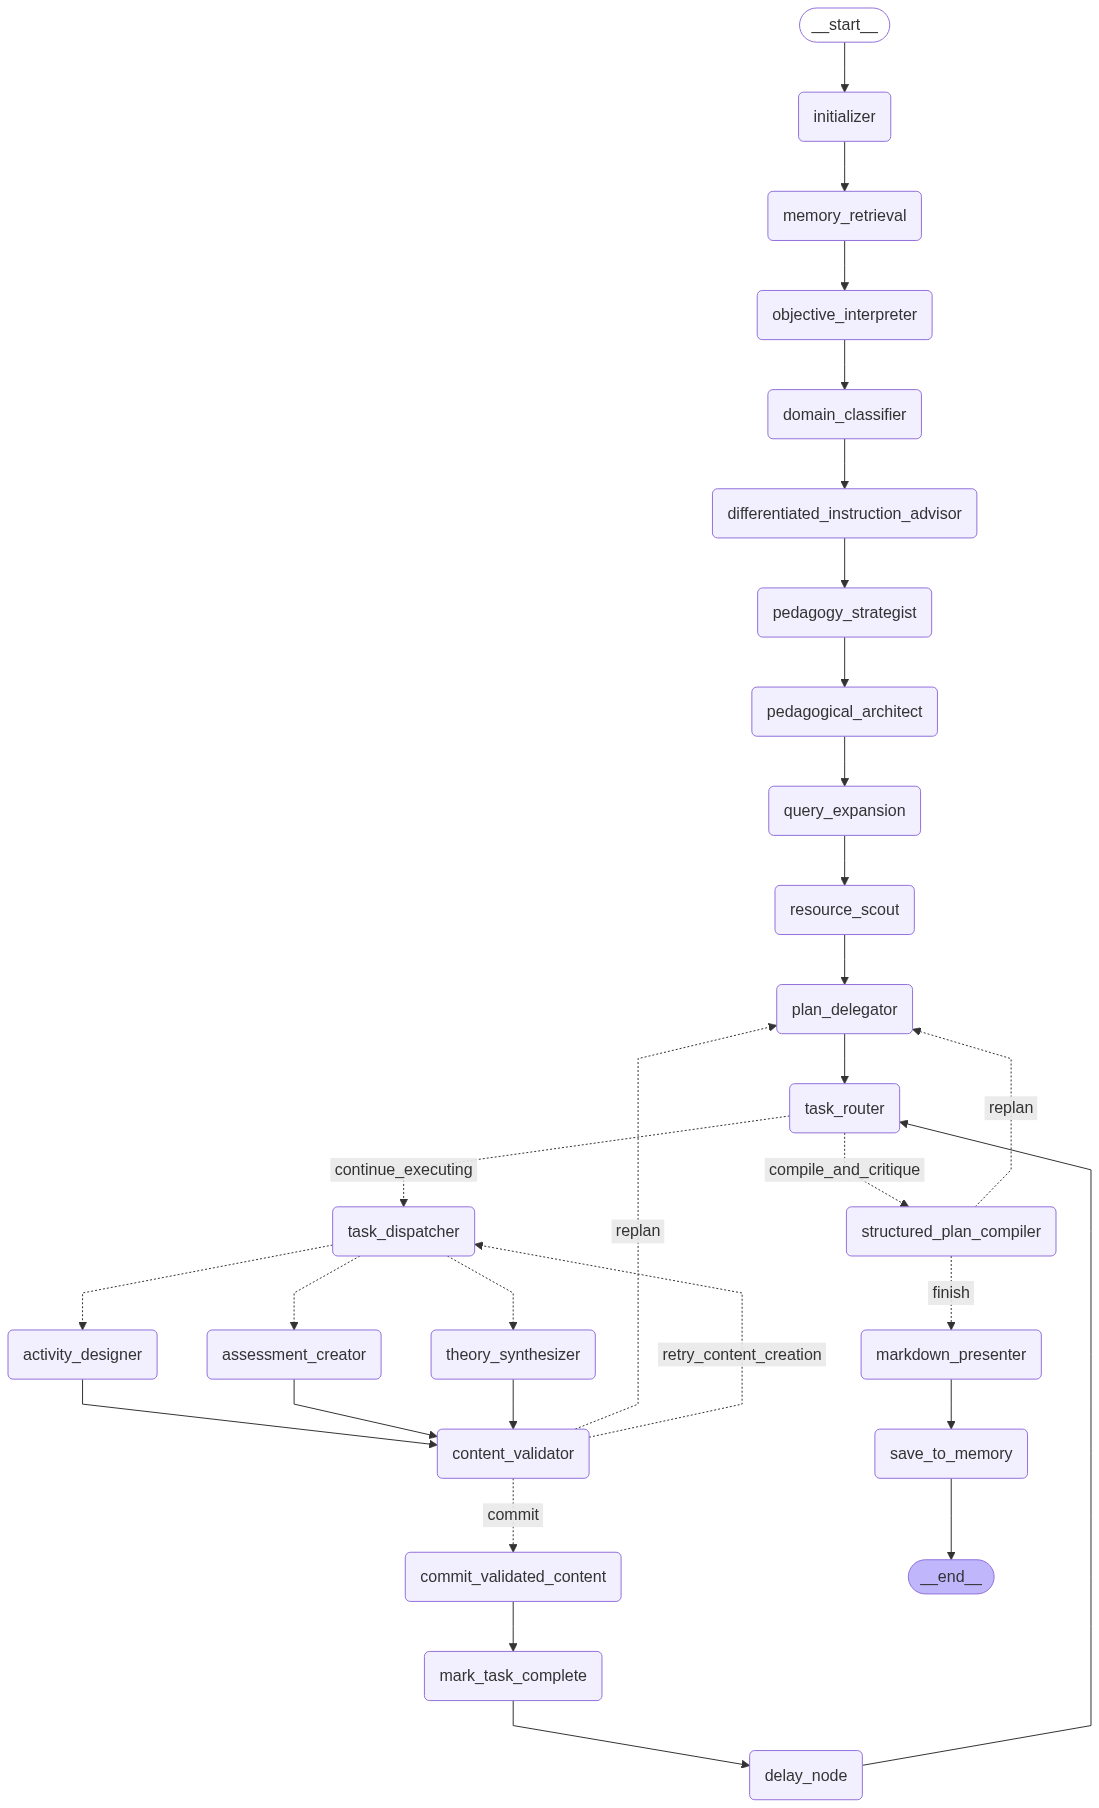

In [17]:
# ==============================================================================
# CELL 4.4: HIỂN THỊ SƠ ĐỒ GRAPH (TÙY CHỌN)
# ==============================================================================
try:
    # Lệnh này sẽ vẽ một sơ đồ của workflow, rất hữu ích để gỡ lỗi
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Lỗi vẽ biểu đồ: {e}. Đây là lỗi không nghiêm trọng, bạn vẫn có thể chạy quy trình.")

## PHẦN 5

In [18]:
# ==============================================================================
# CELL 5.1: ĐỊNH NGHĨA HÀM CHẠY QUY TRÌNH (v12.0 - HOÀN THIỆN)
# ==============================================================================
async def run_architect(user_request: str):
    if 'llm' not in globals() or llm is None:
        print_warning("LLM chưa được khởi tạo.")
        return
    if 'vector_store' not in globals() or vector_store is None:
        print_warning("Kho tri thức chưa được tải.")
        return
    if 'app' not in globals():
        print_warning("Graph 'app' chưa được biên dịch.")
        return

    initial_state = {"messages": [HumanMessage(content=user_request)]}
    console.print(f"\n[bold magenta]🚀 BẮT ĐẦU QUY TRÌNH V12.0 (HOÀN THIỆN) VỚI YÊU CẦU:[/bold magenta]\n> {user_request}")
    config = {"recursion_limit": 150} 
    
    final_markdown_plan = None
    final_structured_plan = None
    
    try:
        async for event in app.astream(initial_state, config=config):
            for node_name, node_output in event.items():
                console.print(f"\n[bold yellow]------- Hoàn thành bước: {node_name} -------[/bold yellow]")
                if node_name == "markdown_presenter":
                    final_markdown_plan = node_output.get("final_markdown_plan")
                    final_structured_plan = node_output.get("final_structured_plan")

        console.print("\n[bold magenta]🏁 KẾT THÚC QUY TRÌNH.[/bold magenta]")
        
        if final_markdown_plan:
            console.print("\n[bold green]📝 GIÁO ÁN HOÀN CHỈNH (v12.0)[/bold green]")
            console.print(Markdown(final_markdown_plan))
            
            if VERBOSE_MODE and final_structured_plan:
                print_result(final_structured_plan, "Output JSON có cấu trúc")
        else:
            print_warning("Không tạo được giáo án cuối cùng. Vui lòng kiểm tra log để gỡ lỗi.")
            
    except Exception as e:
        print_warning(f"Đã xảy ra lỗi nghiêm trọng trong quá trình chạy graph: {e}")
        import traceback
        traceback.print_exc()

print("✅ Hàm `run_architect` (v12.0) đã sẵn sàng để sử dụng.")

✅ Hàm `run_architect` (v12.0) đã sẵn sàng để sử dụng.


In [ ]:
# ==============================================================================
# CELL 5.2: KÍCH HOẠT CHẠY THỬ NGHIỆM
# ==============================================================================
# Yêu cầu để kiểm tra
architect_request = "Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao."
VERBOSE_MODE = True 

# Chạy quy trình đã được cải cách
# Lưu ý: bạn cần một môi trường hỗ trợ `await` ở cấp độ cao nhất (như Jupyter Notebook)
await run_architect(architect_request)

🚀 BẮT ĐẦU QUY TRÌNH V12.0 (HOÀN THIỆN) VỚI YÊU CẦU:
> Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là
một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao.

> `Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...

------- Hoàn thành bước: initializer -------

> `Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...

✔️ Tìm thấy ví dụ tương đồng trong trí nhớ:

"Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao."

------- Hoàn thành bước: memory_retrieval -------

> `Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...

✔️ Mục tiêu & Ràng buộc đã phân tích:

{
│   'action_verb': 'Thiết kế',
│   'bloom_level': 2,
│   'topic': 'Đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'grade_level': 'Lớp 9',
│   'constraints': {
│   │   'duration_minutes': 90
│   }
}

------- Hoàn thành bước: objective_interpreter -------

> `Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...

✔️ Lĩnh vực chuyên môn được xác định:

'Toán học'

------- Hoàn thành bước: domain_classifier -------

> `Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...

✔️ Hồ sơ lớp học và Chiến lược Phân hóa:

{
│   'learning_pace': 'chậm',
│   'engagement_style': 'thụ động',
│   'special_notes': 'Lớp học có tốc độ tiếp thu chậm, dễ mất tập trung và cần nhiều hoạt động tương tác để duy trì sự chú ý và hứng thú học tập.',
│   'differentiation_strategy': {
│   │   'for_struggling_students': 'Chia nhỏ kiến thức thành các phần nhỏ, sử dụng nhiều ví dụ minh họa trực quan, cung cấp phiếu bài tập có gợi ý hoặc công thức mẫu. Tăng cường kiểm tra, củng cố kiến thức ngay sau mỗi phần. Khuyến khích học sinh yếu làm việc nhóm với sự hỗ trợ của bạn bè.',
│   │   'for_advanced_students': 'Giao các bài tập nâng cao, mở rộng hoặc các bài toán ứng dụng thực tế liên quan đến đường tròn. Khuyến khích các em tự tìm hiểu thêm về các tính chất đặc biệt của đường tròn hoặc các bài toán chứng minh phức tạp hơn. Cho phép các em hỗ trợ, hướng dẫn các bạn trong nhóm.'
│   }
}

------- Hoàn thành bước: differentiated_instruction_advisor -------

> `Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...

✔️ Chiến lược sư phạm chi tiết:

{
│   'name': 'Dạy học hợp tác (Cooperative Learning)',
│   'rationale': "Phương pháp dạy học hợp tác rất phù hợp với lớp học có tốc độ tiếp thu chậm và dễ mất tập trung. Việc chia nhóm giúp tăng cường tương tác giữa các học sinh, khuyến khích sự chủ động và giảm bớt sự thụ động. Học sinh yếu sẽ nhận được sự hỗ trợ từ bạn bè trong nhóm, trong khi học sinh khá giỏi có cơ hội củng cố kiến thức và phát triển kỹ năng lãnh đạo. Các hoạt động nhóm cũng giúp chia nhỏ kiến thức thành các phần dễ tiếp cận hơn, duy trì sự hứng thú và cho phép học sinh cùng nhau 'thiết kế' (vẽ, xác định) các đường tròn ngoại tiếp và nội tiếp một cách thực hành, ứng dụng.",
│   'key_actions': [
│   │   'Giới thiệu mục tiêu và chia nhóm học sinh (có sự phân hóa)',
│   │   'Giao nhiệm vụ học tập theo nhóm (phiếu bài tập, bài toán thực hành về đường tròn ngoại tiếp/nội tiếp)',
│   │   "Học sinh làm việc nhóm, thảo luận và cùng nhau 'thiết kế' (vẽ, xác định) các yếu tố của đường tròn",
│   │   'Đại diện nhóm trình bày kết quả và sản phẩm của nhóm',
│   │   'Giáo viên tổng kết, củng cố kiến thức và giải đáp thắc mắc'
│   ]
}

------- Hoàn thành bước: pedagogy_strategist -------

> `Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...

✔️ Bản thiết kế Sư phạm đã được tạo:

[
│   'Giai đoạn 1: Khởi động và Kết nối "Thế giới quanh ta": Giáo viên trình chiếu các hình ảnh/video về các vật thể, kiến trúc, hoa văn có hình dạng đường tròn ngoại tiếp/nội tiếp trong đời sống (ví dụ: bánh xe, đồng hồ, logo, hoa văn trang trí, kiến trúc cổ). Đặt các câu hỏi gợi mở như: "Các em có nhận thấy mối liên hệ nào giữa các hình đa giác và đường tròn trong những hình ảnh này không?", "Theo các em, tại sao người ta lại thiết kế như vậy?". Khuyến khích học sinh chia sẻ suy nghĩ ban đầu để tạo sự kết nối và hứng thú.',
│   'Giai đoạn 2: Khám phá và "Thiết kế" Đường tròn Ngoại tiếp: Giáo viên chia lớp thành các nhóm nhỏ (3-4 học sinh, có sự phân hóa trình độ). Mỗi nhóm nhận một phiếu học tập có in sẵn các tam giác/đa giác khác nhau. Nhiệm vụ của nhóm là thảo luận, tìm cách xác định tâm và bán kính của đường tròn ngoại tiếp các hình đó, sau đó dùng compa để vẽ đường tròn. Giáo viên đi quanh các nhóm, quan sát, gợi ý (ví dụ: "Các em thử nhớ lại các đường đặc biệt trong tam giác?") và hỗ trợ khi cần thiết, đặc biệt với các nhóm có học sinh yếu.',
│   'Giai đoạn 3: Khám phá và "Thiết kế" Đường tròn Nội tiếp: Tiếp nối hoạt động nhóm, giáo viên cung cấp phiếu học tập mới hoặc yêu cầu các nhóm sử dụng hình vẽ đã có để khám phá đường tròn nội tiếp. Nhiệm vụ là thảo luận, tìm cách xác định tâm và bán kính của đường tròn nội tiếp các hình đã cho, sau đó vẽ đường tròn đó. Giáo viên tiếp tục quan sát, gợi ý (ví dụ: "Đường tròn nội tiếp có liên hệ gì với các cạnh của tam giác?") và hỗ trợ để đảm bảo tất cả học sinh đều tham gia và hiểu bài.',
│   'Giai đoạn 4: Vận dụng và Giải quyết vấn đề "Kỹ sư trẻ": Giáo viên giao cho mỗi nhóm một bài toán ứng dụng thực tế hoặc một bài tập tổng hợp yêu cầu kết hợp cả hai loại đường tròn (ví dụ: "Thiết kế một bồn hoa hình tam giác đều sao cho có thể đặt một đài phun nước hình tròn lớn nhất bên trong và một hàng rào hình tròn bao quanh bên ngoài"). Các nhóm thảo luận, đưa ra phương án giải quyết và trình bày sản phẩm (có thể là bản vẽ hoặc sơ đồ). Giáo viên khuyến khích các nhóm trình bày cách giải, đặt câu hỏi phản biện để học sinh phát triển tư duy sâu hơn.',
│   'Giai đoạn 5: Tổng kết và Củng cố "Chốt hạ kiến thức": Giáo viên tổng kết các khái niệm, tính chất quan trọng về đường tròn ngoại tiếp và nội tiếp. Tổ chức một trò chơi hỏi đáp nhanh hoặc bài tập trắc nghiệm ngắn (3-5 câu) để kiểm tra nhanh kiến thức của học sinh. Giao bài tập về nhà để học sinh củng cố và mở rộng kiến thức đã học. Nhấn mạnh tầm quan trọng của việc luyện tập thường xuyên.'
]

------- Hoàn thành bước: pedagogical_architect -------

> `Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...

✔️ Các truy vấn tìm kiếm đã được mở rộng:

[
│   'đường tròn ngoại tiếp và nội tiếp',
│   'công thức đường tròn ngoại tiếp tam giác',
│   'công thức đường tròn nội tiếp tam giác',
│   'tính bán kính đường tròn ngoại tiếp',
│   'tính bán kính đường tròn nội tiếp',
│   'bài tập đường tròn ngoại tiếp nội tiếp lớp 9',
│   'chuyên đề đường tròn ngoại tiếp và nội tiếp',
│   'lý thuyết đường tròn ngoại tiếp',
│   'lý thuyết đường tròn nội tiếp',
│   'ứng dụng đường tròn ngoại tiếp nội tiếp',
│   'quan hệ giữa đường tròn ngoại tiếp và nội tiếp',
│   'đường tròn bàng tiếp tam giác',
│   'cách vẽ đường tròn ngoại tiếp tam giác',
│   'cách vẽ đường tròn nội tiếp tam giác',
│   'đường tròn ngoại tiếp tam giác vuông',
│   'đường tròn nội tiếp tam giác đều',
│   'đường tròn ngoại tiếp tứ giác',
│   'bài tập nâng cao đường tròn ngoại tiếp nội tiếp',
│   'ôn thi đường tròn ngoại tiếp nội tiếp',
│   'toán hình học đường tròn ngoại tiếp nội tiếp'
]

------- Hoàn thành bước: query_expansion -------

> `Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...

> Tìm thấy 100 tài liệu, sàng lọc còn 8 đoạn văn bản độc nhất.

✔️ Tài liệu RAG cuối cùng:

{
│   'source': 'Sách giáo khoa (từ RAG - đã sàng lọc)',
│   'summary': 'Chào em, với vai trò là một giáo viên giàu kinh nghiệm, thầy sẽ giúp em tổng hợp kiến thức cốt lõi về chủ đề "Đường tròn ngoại tiếp và đường tròn nội tiếp" dựa **duy nhất** vào các đoạn văn bản em đã cung cấp.\n\n---\n\n**TÓM TẮT KIẾN THỨC CỐT LÕI VỀ ĐƯỜNG TRÒN NGOẠI TIẾP VÀ TIẾP TUYẾN CỦA ĐƯỜNG TRÒN**\n\nDựa trên các đoạn văn bản được cung cấp, kiến thức cốt lõi có thể được tổng hợp như sau:\n\n**1. Đường tròn đi qua các đỉnh của đa giác (Đường tròn ngoại tiếp)**\n\n*   **Khái niệm (suy luận từ bài tập):** Một đường tròn có thể đi qua tất cả các đỉnh của một đa giác. Đường tròn này được gọi là đường tròn ngoại tiếp đa giác đó.\n*   **Các trường hợp cụ thể được đề cập:**\n    *   **Đối với tam giác vuông:** Các điểm A, B, C là các đỉnh của một tam giác vuông có thể thuộc cùng một đường tròn (Bài 5.2). Bán kính của đường tròn này có thể được tính toán.\n    *   **Đối với hình vuông:** Bốn đỉnh của một hình vuông (A, B, C, D) có thể thuộc cùng một đường tròn (Bài 5.4a). Tâm của đường tròn này là giao điểm của hai đường chéo của hình vuông. Bán kính của đường tròn này có thể được tính toán dựa vào độ dài cạnh của hình vuông (Bài 5.4b).\n\n**2. Tiếp tuyến của Đường tròn**\n\n*   **Định nghĩa:**\n    *   Đường thẳng và đường tròn được gọi là **tiếp xúc với nhau** nếu chúng có đúng một điểm chung.\n    *   Điểm chung đó được gọi là **tiếp điểm**.\n    *   Khi đó, đường thẳng còn được gọi là **tiếp tuyến** của đường tròn tại tiếp điểm đó (Trang 100).\n*   **Dấu hiệu nhận biết tiếp tuyến:**\n    *   Nếu một đường thẳng đi qua một điểm trên một đường tròn và vuông góc với bán kính đi qua điểm đó, thì đường thẳng ấy là một tiếp tuyến của đường tròn (Định lí 1, Trang 100).\n*   **Mối quan hệ giữa khoảng cách từ tâm và bán kính:**\n    *   Cho đường thẳng a và đường tròn (O; R). Gọi d là khoảng cách từ tâm O đến đường thẳng a.\n    *   Đường thẳng a và đường tròn (O; R) tiếp xúc với nhau khi và chỉ khi $d = R$ (Nhận xét, Trang 100).\n\n---\n**Lưu ý của giáo viên:** Các đoạn văn bản được cung cấp không chứa thông tin trực tiếp về "đường tròn nội tiếp". Do đó, phần tóm tắt này chỉ tập trung vào "đường tròn ngoại tiếp" (dưới dạng đường tròn đi qua các đỉnh của đa giác) và "tiếp tuyến của đường tròn" là những khái niệm có liên quan và được đề cập rõ ràng trong tài liệu.'
}

------- Hoàn thành bước: resource_scout -------

> `Agent: Plan Delegator` (v12.0 - Nhà hoạch định Thông thái) đang triển khai...

✔️ Đã tạo 5 nhiệm vụ chi tiết:

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và Kết nối "Thế giới quanh ta"',
│   │   'task_description': 'Giáo viên trình chiếu hình ảnh/video về các vật thể, kiến trúc, hoa văn có hình dạng đường tròn ngoại tiếp/nội tiếp trong đời sống. Đặt câu hỏi gợi mở và khuyến khích học sinh chia sẻ suy nghĩ ban đầu để tạo sự kết nối và hứng thú.',
│   │   'estimated_duration': 12,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá và "Thiết kế" Đường tròn Ngoại tiếp',
│   │   'task_description': 'Chia lớp thành các nhóm nhỏ. Mỗi nhóm nhận phiếu học tập có in sẵn các tam giác/đa giác. Nhiệm vụ là thảo luận, tìm cách xác định tâm và bán kính của đường tròn ngoại tiếp, sau đó dùng compa để vẽ. Giáo viên quan sát, gợi ý và hỗ trợ khi cần thiết.',
│   │   'estimated_duration': 28,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Khám phá và "Thiết kế" Đường tròn Nội tiếp',
│   │   'task_description': 'Tiếp nối hoạt động nhóm, cung cấp phiếu học tập mới hoặc yêu cầu sử dụng hình vẽ đã có để khám phá đường tròn nội tiếp. Nhiệm vụ là thảo luận, tìm cách xác định tâm và bán kính, sau đó vẽ đường tròn đó. Giáo viên tiếp tục quan sát, gợi ý và hỗ trợ.',
│   │   'estimated_duration': 28,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Vận dụng và Giải quyết vấn đề "Kỹ sư trẻ"',
│   │   'task_description': 'Giao cho mỗi nhóm một bài toán ứng dụng thực tế hoặc bài tập tổng hợp yêu cầu kết hợp cả hai loại đường tròn. Các nhóm thảo luận, đưa ra phương án giải quyết và trình bày sản phẩm (bản vẽ hoặc sơ đồ). Giáo viên khuyến khích trình bày cách giải và đặt câu hỏi phản biện.',
│   │   'estimated_duration': 18,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Tổng kết và Củng cố "Chốt hạ kiến thức"',
│   │   'task_description': 'Giáo viên tổng kết các khái niệm, tính chất quan trọng. Tổ chức trò chơi hỏi đáp nhanh hoặc bài tập trắc nghiệm ngắn để kiểm tra nhanh kiến thức. Giao bài tập về nhà để học sinh củng cố và mở rộng kiến thức.',
│   │   'estimated_duration': 4,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và Kết nối "Thế giới quanh ta"' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khởi động và Kết nối "Thế giới quanh ta"',
│   'duration_minutes': 12,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu và quy tắc hoạt động (1 phút).',
│   │   'Chia nhóm/cặp và hướng dẫn rõ ràng về việc chia sẻ và lắng nghe (1 phút).',
│   │   'Đi quanh lớp, lắng nghe các cuộc thảo luận, gợi ý hoặc hỗ trợ các nhóm gặp khó khăn (5-6 phút).',
│   │   'Quản lý thời gian, báo hiệu khi còn 2 phút để các nhóm chuẩn bị chia sẻ.',
│   │   'Mời 2-3 nhóm đại diện chia sẻ nhanh điều thú vị của nhóm mình trước lớp (3-4 phút).',
│   │   'Tổng kết ngắn gọn, khen ngợi sự đa dạng của các chia sẻ và kết nối với nội dung bài học sắp tới.'
│   ],
│   'core_component': 'Học sinh làm việc theo cặp/nhóm nhỏ (3-4 người). Mỗi học sinh lần lượt chia sẻ một điều thú vị (sự kiện, hiện tượng, phát minh, câu chuyện,...) mà em biết về thế giới xung quanh mình trong thời gian gần đây. Các thành viên lắng nghe, đặt câu hỏi ngắn gọn hoặc bày tỏ sự ngạc nhiên/thích thú. Sau đó, nhóm chọn ra 1-2 điều thú vị nhất để chuẩn bị chia sẻ nhanh trước lớp.',
│   'extension_component': 'Các nhóm đã hoàn thành phần cốt lõi có thể suy nghĩ thêm về một câu hỏi lớn liên quan đến điều thú vị mà họ đã chia sẻ, hoặc tìm cách kết nối điều đó với một lĩnh vực kiến thức khác (ví dụ: khoa học, lịch sử, địa lý).',
│   'solution_guide': None,
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp các gợi ý bằng hình ảnh hoặc từ khóa (ví dụ: động vật, cây cối, thời tiết, tin tức, phát minh). Khuyến khích các em chỉ cần nói một câu đơn giản hoặc chỉ ra một hình ảnh. Ghép cặp với học sinh khá hơn để được hỗ trợ và lắng nghe.',
│   │   'for_advanced_students': "Yêu cầu các em không chỉ chia sẻ mà còn giải thích ngắn gọn 'tại sao' điều đó thú vị hoặc 'nó liên quan đến điều gì'. Thử thách các em đặt câu hỏi mở cho các bạn trong nhóm để khuyến khích tư duy sâu hơn."
│   },
│   'content_type': 'Thảo luận nhóm và chia sẻ'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Editor Critic` (v12.2 - Biên tập viên) đang thẩm định và sửa lỗi...

⚠️  ⚠️ EDITOR CRITIC: Nội dung không hợp lệ và không thể sửa. Yêu cầu thử lại từ đầu.

⚠️  ROUTER (Editor): Critic không sửa được. Yêu cầu Agent chuyên môn thử lại lần 1/1.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khởi động và Kết nối "Thế giới quanh ta"',
│   'duration_minutes': 12,
│   'teacher_actions': [
│   │   'Giới thiệu hoạt động và mục tiêu kết nối với chủ đề "Thế giới quanh ta".',
│   │   'Giải thích rõ yêu cầu: mỗi học sinh chia sẻ một điều thú vị/hiện tượng tự nhiên đã quan sát được hoặc nghe nói đến.',
│   │   'Cho học sinh 1 phút suy nghĩ cá nhân.',
│   │   'Yêu cầu học sinh chia sẻ trong nhóm nhỏ (2-3 người) trong 5 phút.',
│   │   'Quan sát, lắng nghe, đi lại giữa các nhóm để hỗ trợ và gợi mở nếu cần.',
│   │   'Mời 2-3 học sinh/nhóm đại diện chia sẻ trước lớp trong 4 phút.',
│   │   'Tổng kết các ý kiến, nhấn mạnh sự đa dạng của "thế giới quanh ta" và kết nối vào bài học mới trong 2 phút.'
│   ],
│   'core_component': 'Học sinh suy nghĩ cá nhân trong 1 phút, sau đó chia sẻ với bạn bên cạnh (hoặc trong nhóm 2-3 người) về "Một điều thú vị hoặc một hiện tượng tự nhiên mà em đã quan sát được hoặc nghe nói đến trong cuộc sống hàng ngày của mình". Sau đó, giáo viên mời 2-3 học sinh/nhóm đại diện chia sẻ trước lớp.',
│   'extension_component': 'Nếu còn thời gian hoặc đối với học sinh hoàn thành nhanh, các em có thể vẽ nhanh một hình ảnh minh họa cho điều mình đã chia sẻ hoặc viết một câu ngắn gọn mô tả cảm xúc của mình về điều đó.',
│   'solution_guide': 'Gợi ý các câu hỏi để giáo viên khơi gợi nếu học sinh gặp khó khăn: "Trên đường đi học hôm nay, em đã thấy gì đặc biệt?", "Thời tiết hôm nay có gì khác lạ không?", "Em có nghe thấy tiếng chim hót hay tiếng gió thổi không?", "Có loài cây hay con vật nào ở gần nhà em mà em thấy thú vị không?"',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể gợi ý các chủ đề cụ thể hơn như: "Em có thể kể về một loài cây, một con vật, một hiện tượng thời tiết (mưa, nắng, gió), hoặc một âm thanh tự nhiên mà em đã nghe thấy gần đây". Khuyến khích các em chia sẻ ngắn gọn, không cần quá chi tiết.',
│   │   'for_advanced_students': 'Khuyến khích các em giải thích sâu hơn về điều mình quan sát được: "Điều đó khiến em cảm thấy thế nào?", "Em có muốn tìm hiểu thêm về điều đó không?", "Tại sao em lại thấy điều đó thú vị?". Có thể yêu cầu các em đặt câu hỏi cho bạn sau khi chia sẻ.'
│   },
│   'content_type': 'Thảo luận nhóm nhỏ và chia sẻ cả lớp'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Editor Critic` (v12.2 - Biên tập viên) đang thẩm định và sửa lỗi...

> ✔️ EDITOR CRITIC: Đã biên tập lại nội dung cho phù hợp!

✔️ Nội dung đã được Editor Critic biên tập lại:

{
│   'activity_name': 'Tên hoạt động',
│   'activity_type': 'Loại hoạt động',
│   'duration_minutes': 0,
│   'teacher_actions': [],
│   'core_component': 'Nội dung cốt lõi',
│   'extension_component': 'Nội dung mở rộng',
│   'solution_guide': 'Hướng dẫn giải',
│   'differentiation': {
│   │   'for_struggling_students': 'Gợi ý cho học sinh yếu.',
│   │   'for_advanced_students': 'Thử thách cho học sinh giỏi.'
│   }
}

> ROUTER (Editor): Nội dung đã được duyệt. Chuyển sang ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khám phá và "Thiết kế" Đường tròn Ngoại tiếp' (ID: 1)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá và "Thiết kế" Đường tròn Ngoại tiếp',
│   'duration_minutes': 28,
│   'teacher_actions': [
│   │   'Giới thiệu nhiệm vụ và mục tiêu của hoạt động: tìm tâm và vẽ đường tròn đi qua ba đỉnh của tam giác.',
│   │   'Phát phiếu học tập (có thể có hình tam giác mẫu hoặc yêu cầu học sinh tự vẽ) và dụng cụ (thước, compa).',
│   │   'Quan sát, đi lại giữa các nhóm/cá nhân, hỗ trợ khi cần thiết, đặc biệt là trong việc dựng đường trung trực.',
│   │   'Đặt câu hỏi gợi mở: "Làm thế nào để tìm một điểm cách đều ba đỉnh của tam giác?", "Điểm đó có mối liên hệ gì với các đường đặc biệt trong tam giác?"',
│   │   'Yêu cầu các nhóm/cá nhân trình bày kết quả và cách làm của mình, chia sẻ những phát hiện.',
│   │   'Tổng kết kiến thức về tâm và bán kính đường tròn ngoại tiếp, chốt lại vị trí của tâm đối với các loại tam giác.'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm nhỏ (hoặc cá nhân) để thực hiện các bước sau:\n1.  Vẽ một tam giác bất kỳ (hoặc sử dụng tam giác cho sẵn trên phiếu học tập).\n2.  Sử dụng thước và compa để dựng các đường trung trực của hai cạnh bất kỳ của tam giác.\n3.  Xác định giao điểm của hai đường trung trực này.\n4.  Kiểm tra xem điểm vừa tìm được có cách đều ba đỉnh của tam giác hay không bằng cách đo khoảng cách hoặc dùng compa.\n5.  Vẽ đường tròn đi qua ba đỉnh của tam giác (đường tròn ngoại tiếp).',
│   'extension_component': 'Đối với học sinh hoàn thành sớm hoặc còn dư thời gian:\n1.  Thử nghiệm với các loại tam giác khác nhau (tam giác vuông, tam giác tù) để quan sát vị trí của tâm đường tròn ngoại tiếp.\n2.  Nêu nhận xét về vị trí của tâm đường tròn ngoại tiếp đối với tam giác nhọn, vuông, tù.\n3.  Thử thách: Có thể vẽ một đường tròn đi qua bốn đỉnh của một tứ giác bất kỳ không? Giải thích tại sao có hoặc không.',
│   'solution_guide': 'Gợi ý giải:\n- Tâm đường tròn ngoại tiếp tam giác là giao điểm của ba đường trung trực của ba cạnh tam giác.\n- Bán kính đường tròn ngoại tiếp là khoảng cách từ tâm đến bất kỳ đỉnh nào của tam giác.\n- Vị trí tâm đường tròn ngoại tiếp:\n  - Tam giác nhọn: Tâm nằm bên trong tam giác.\n  - Tam giác vuông: Tâm là trung điểm của cạnh huyền.\n  - Tam giác tù: Tâm nằm bên ngoài tam giác.\n- Đối với tứ giác: Chỉ có thể vẽ đường tròn đi qua bốn đỉnh của một tứ giác khi tứ giác đó là tứ giác nội tiếp (tổng hai góc đối bằng 180 độ).',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp phiếu học tập có sẵn các tam giác đã vẽ rõ ràng, hoặc thậm chí có sẵn một đường trung trực để học sinh chỉ cần dựng đường trung trực thứ hai. Hướng dẫn từng bước cụ thể hơn, có thể làm mẫu một phần nhỏ. Tập trung vào việc dựng đúng một đường trung trực và tìm giao điểm.',
│   │   'for_advanced_students': 'Yêu cầu học sinh chứng minh tại sao giao điểm của các đường trung trực lại cách đều ba đỉnh. Khuyến khích học sinh tìm hiểu thêm về các đường đặc biệt khác trong tam giác (đường cao, đường trung tuyến, đường phân giác) và mối liên hệ của chúng với tâm đường tròn ngoại tiếp (nếu phù hợp với chương trình). Có thể yêu cầu tìm hiểu về đường Euler.'
│   },
│   'content_type': 'Thực hành nhóm và cá nhân'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Editor Critic` (v12.2 - Biên tập viên) đang thẩm định và sửa lỗi...

⚠️  ⚠️ EDITOR CRITIC: Nội dung không hợp lệ và không thể sửa. Yêu cầu thử lại từ đầu.

⚠️  ROUTER (Editor): Critic không sửa được. Yêu cầu Agent chuyên môn thử lại lần 1/1.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v12.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá và "Thiết kế" Đường tròn Ngoại tiếp',
│   'duration_minutes': 28,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu bài học: "Hôm nay chúng ta sẽ cùng khám phá cách xác định và vẽ đường tròn ngoại tiếp một tam giác."',
│   │   'Phát phiếu học tập (có sẵn tam giác ABC) và dụng cụ (thước, compa) cho các nhóm.',
│   │   'Hướng dẫn học sinh thảo luận nhóm để tìm cách vẽ đường tròn đi qua 3 đỉnh của tam giác.',
│   │   'Quan sát, đi lại giữa các nhóm, gợi ý khi cần (ví dụ: "Đường tròn đi qua 3 đỉnh có gì đặc biệt?", "Tâm đường tròn cách đều 3 đỉnh, vậy nó nằm trên đường nào?").',
│   │   'Yêu cầu đại diện 1-2 nhóm trình bày kết quả và cách làm trước lớp.',
│   │   'Tổng kết, chốt kiến thức về tâm đường tròn ngoại tiếp (giao điểm 3 đường trung trực) và cách vẽ.'
│   ],
│   'core_component': 'Mỗi nhóm nhận một phiếu học tập có vẽ sẵn một tam giác thường ABC. Nhiệm vụ của nhóm là thảo luận và sử dụng thước, compa để vẽ một đường tròn đi qua cả ba đỉnh A, B, C của tam giác đó. Sau khi vẽ xong, hãy ghi lại các bước thực hiện và giải thích tại sao tâm đường tròn lại nằm ở vị trí đó.',
│   'extension_component': 'Nếu hoàn thành sớm, các nhóm hãy thử vẽ đường tròn ngoại tiếp cho một tam giác vuông hoặc một tam giác tù. Quan sát và nhận xét về vị trí tâm đường tròn ngoại tiếp trong các trường hợp này.',
│   'solution_guide': 'Gợi ý:\n1. Tâm đường tròn ngoại tiếp tam giác là điểm cách đều ba đỉnh của tam giác.\n2. Tập hợp các điểm cách đều hai điểm A và B là đường gì? (Đường trung trực của đoạn thẳng AB).\n3. Vậy, để tìm tâm đường tròn ngoại tiếp, ta cần tìm giao điểm của các đường nào?',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp phiếu học tập có gợi ý chi tiết hơn về các bước vẽ đường trung trực của từng cạnh. Giáo viên có thể trực tiếp hướng dẫn nhóm vẽ một đường trung trực đầu tiên để làm mẫu hoặc cung cấp một tam giác có các cạnh dễ vẽ đường trung trực hơn.',
│   │   'for_advanced_students': 'Yêu cầu học sinh chứng minh tại sao giao điểm của ba đường trung trực lại là tâm đường tròn ngoại tiếp. Hoặc yêu cầu họ tìm mối liên hệ giữa bán kính đường tròn ngoại tiếp và các cạnh của tam giác (nếu có thể).'
│   },
│   'content_type': 'Thực hành và Thảo luận nhóm'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Editor Critic` (v12.2 - Biên tập viên) đang thẩm định và sửa lỗi...